# Monte Carlo Sampling

Consider a bivariate Gaussian distribution $N (\mu, \Sigma)$, where <br>$\mu = (4, 2)$,

$\Sigma=\begin{pmatrix}
1.44 & -0.702 \\
-0.702 & 0.81 
\end{pmatrix}	$<br>

Assume that such distribution describes the posterior of two parameters $x_1$ and $x_2$.
1. Plot contours of this distribution and tell what are the boundaries of the 95% credibile interval for each parameter, after marginalizing over the other. 
2. Tell how these boundaries change if, instead of marginalizing, we fix either parameter to a known value. 
3. Now, re-obtain the same boundaries via Monte Carlo sampling of the posterior, in three ways: <br>
    a. by directly drawing values of $(x_1 , x_2 )$, by mean of a Cholesky decomposition of the covariance (check in the literature how to do this); <br>
    b. Via Metropolis-Hastings sampling of the posterior;<br>
    c. Via Gibbs sampling of the posterior. 

In all cases, do not rely on pre-made code, but write your own (i.e., you can surely use libraries to generate known distributions, do Cholesky decomposition, and so on, but you should not use a pre-made library with a command like ”Gibbs-sampling”). <br> In all cases, provide final contour plots, and marginalized posteriors. In the MCMC analysis, produce also trace plots to test for convergence of the chains.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
from sklearn.datasets import make_spd_matrix

np.random.seed(20032020)

In [2]:
#initializing covariance matrix and mean
cov=np.array([1.44,-0.702,-0.702,0.81]).reshape(2,2)
mu=np.array([4.,2.])

#unnormalized MVG
def unnorm_post(x,mean,cov):
    f=np.exp(-0.5*(np.dot((x-mean).T,np.dot(np.linalg.inv(cov),x-mean))))
    return f

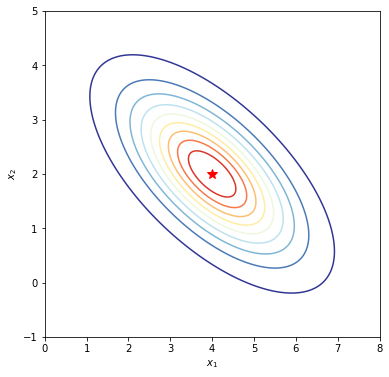

In [3]:
#Plotting contours of a bivariate gaussian
def contours(mu,cov,ax=plt.subplots(figsize=(6, 6))[1]):    
    npts=1000
    x, y = np.meshgrid(np.linspace(0,8,npts), np.linspace(-2,8,npts))
    pos = np.empty(x.shape + (2,))
    pos[:, :, 0] = x; pos[:, :, 1] = y
    rv=stats.multivariate_normal(mu,cov)
    cax = ax.contour(x, y, rv.pdf(pos),cmap="RdYlBu_r",levels=np.linspace(0.01,np.max(rv.pdf(pos)),10))
    ax.plot(mu[0],mu[1],'r*',markersize=10)
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.set_ylim(-1,5)
    ax.set_xlim(0,8)
contours(mu,cov)

### Expected confidence intervals

In [4]:
percentual=0.95

print(str(int(percentual*100))+'% credibility interval for for each parameter, after marginalizing over the other: ')
print(' x1: ',stats.norm.interval(percentual, loc=mu[0], scale=np.sqrt(cov[0,0])))
print(' x2: ',stats.norm.interval(percentual, loc=mu[1], scale=np.sqrt(cov[1,1])))

fixed_value=2
print(str(int(percentual*100))+'% credibility interval for for each parameter, with the other fixed to '+str(fixed_value))
rho=cov[1,0]/np.sqrt(cov[0,0]*cov[1,1])
print(' x1', stats.norm.interval(percentual,loc=mu[0]+(np.sqrt(cov[0,0]/cov[1,1])*rho*(fixed_value-mu[1])),scale=np.sqrt(1-rho**2)*np.sqrt(cov[0,0]))   )
print(' x2', stats.norm.interval(percentual,loc=mu[1]+(np.sqrt(cov[1,1]/cov[0,0])*rho*(fixed_value-mu[0])),scale=np.sqrt(1-rho**2)*np.sqrt(cov[1,1]))   )

95% credibility interval for for each parameter, after marginalizing over the other: 
 x1:  (1.6480432185519351, 6.351956781448065)
 x2:  (0.23603241391395136, 3.7639675860860486)
95% credibility interval for for each parameter, with the other fixed to 2
 x1 (2.212667586796112, 5.787332413203888)
 x2 (1.6345006900970838, 4.315499309902917)


# Markov Chain Monte Carlo

### 1) Cholesky Decomposition of covariance


In [5]:
#function to cholesky decomposition
def cholesky(cov,lower=True):
    N=len(cov)
    L = np.zeros((N,N))
    for i in np.arange(N):
        for k in np.arange(i+1):
            tmp_sum = sum(L[i,j] * L[k,j] for j in np.arange(k))
            if (i == k):
                L[i,k] = np.sqrt(cov[i,i] - tmp_sum)
            else:
                L[i,k] = (1.0 / L[k,k] * (cov[i,k] - tmp_sum))
    if lower==True:
        return (L)
    else:
        return(L.T)
    
#function to sample values by beans of the cholesky decomposition
#INPUTS: 
#    -mu: 2x1 array. known mean of the parameters 
#    -cov:2x2 array. known covariance matrix
#    -num_epochs: integer. Number of total iterations
#OUTPUT:
#    chain

def cholesky_sampling(mu,cov,num_epochs):
    C=cholesky(cov)
    chain=[]
    for i in np.arange(num_epochs):
        Z=np.random.multivariate_normal(np.zeros(2),np.identity(len(mu)))
        chain.append(mu+np.matmul(C,Z))
    return(np.array(chain))

### 2) Metropolis Hastings Algorithm

In [6]:
#2D Metropolis Hastings algorithm
#INPUTS: 
#    -Ptilde: Funtion. Unnormalized posterior
#    -mu: 2x1 array. known mean of the parameters 
#    -cov:2x2 array. known covariance matrix
#    -num_epochs: integer. Number of total iterations
#    -initial_point: 2x1 array. Starting point of the chain
#    -init_cov: 2x2 array. Initial trial covariance
#    -Debug: Logical. If it true, some values are printed for correctness checking
#OUTPUT:
#    chain,trace

def Metropolis_Hasings2D(Ptilde,mu,cov,num_epochs,initial_point,init_cov,debug):
    chain=[initial_point]
    tr=[-np.log(Ptilde(chain[-1],mu,cov))]
    for i in np.arange(num_epochs):
        trial=np.random.multivariate_normal(mean=chain[-1],cov=init_cov)
        alpha=unnorm_post(trial,mu,cov)/unnorm_post(chain[-1],mu,cov)
        if alpha>=1.:
            chain.append(trial)
        else:
            u=np.random.uniform()
            if u<=alpha:
                chain.append(trial)
            else:
                chain.append(chain[-1])
        tr.append(tr[-1]-np.log(Ptilde(chain[-1],mu,cov))/(i+1))

        if debug==True:
            print('epoch: ',int(i+1))
            print('trial proposed: ',trial)
            print('last chain element: ',chain[-1])
            print('last trace element: ',tr[-1])
    return(np.array(chain),tr)

### 3) Gibbs sampling


In [7]:
#2D Gibbs sampling works only for bivariate gaussian
#INPUTS: 
#    -Ptilde: Funtion. Unnormalized posterior
#    -mu: 2x1 array. known mean of the parameters 
#    -cov:2x2 array. known covariance matrix
#    -num_epochs: integer. Number of total iterations
#    -initial_point: 2x1 array. Starting point of the chain
#    -Debug: Logical. If it true, some values are printed for correctness checking
#OUTPUT:
#    chain,trace

def Gibbs_sampling2D(mu,cov,num_epochs,initial_point,debug):
    #correlation parameter between the 2 parameters
    rho=cov[1,0]/np.sqrt(cov[0,0]*cov[1,1])
    chain=[initial_point]
    tr=[-np.log(unnorm_post(chain[-1],mu,cov))]
    for i in np.arange(num_epochs):    
        #conditional distribution for bivariate gaussian for 1 parameter, having fixed the other
        #update parameter 2
        x2=np.random.normal(loc=mu[1]+(np.sqrt(cov[1,1]/cov[0,0])*rho*(chain[-1][0]-mu[0])),scale=np.sqrt(1-rho**2)*np.sqrt(cov[1,1]))
        #update parameter 1
        x1=np.random.normal(loc=mu[0]+(np.sqrt(cov[0,0]/cov[1,1])*rho*(x2-mu[1])),scale=np.sqrt(1-rho**2)*np.sqrt(cov[0,0]))   
        trial=np.array((x1,x2))
        chain.append(trial)
        tr.append(tr[-1]-np.log(unnorm_post(chain[-1],mu,cov))/(i+1))
        if debug==True:
            print('epoch: ',int(i+1))
            print('last chain element: ',chain[-1])
    return(np.array(chain),tr)

In [8]:
#2D Monte Carlo Sampling2d
#function to sample points from a bivariate gaussian distribution
#by means of the 3 different methods above.

#INPUTS: 
#    -mu: 2x1 array. known mean of the parameters 
#    -cov:2x2 array. known covariance matrix
#    -num_epochs: integer. Number of total iterations
#    -algorithm: STRING. Name of the algorithm the user wants to use
#    -burn_in: OPTIONAL,integer. number of beginning samples to remove
#    -Ptilde: OPTIONAL,function. unnomalized distribution
#    -initial_point: OPTIONAL, 2x1 array. Starting point of the chain
#    -init_cov: OPTIONAL, 2x2 array. Initial trial covariance
#    -Debug: OPTIONAL, Logical. If it true, some values are printed for correctness checking
#    -checks: OPTIONAL, Logical. If it true, Metropolis-Hasting execution provides the trace plot

#OUTPUT:
#    chain

def Monte_Carlo_Sampling2D(mu,cov,num_epochs,algorithm, burn_in=5000,Ptilde=unnorm_post,initial_point=np.array([0,0]),init_cov=make_spd_matrix(2),debug=False,checks=True):
    algorithm=algorithm.lower()
    num_epochs=int(num_epochs)
    burn_in=min(burn_in,int(num_epochs/10))
    if algorithm=='metropolis-hastings':
        print('Running Simulation...')
        chain,tr=Metropolis_Hasings2D(Ptilde,mu,cov,num_epochs,initial_point,init_cov,debug)
        if checks==True:
            plt.plot(np.arange(0,len(chain)),tr,c='r',label='Trace')
            plt.plot([burn_in,burn_in],[min(tr),max(tr)] , 'k-', lw=2,label='Burn-in')
            plt.legend(loc='lower right')
            plt.show()
        
    elif algorithm=='gibbs':
        print('Running Simulation...')
        chain,tr=Gibbs_sampling2D(mu,cov,num_epochs,initial_point,debug)
        if checks==True:
            plt.plot(np.arange(0,len(chain)),tr,c='r',label='Trace')
            plt.plot([burn_in,burn_in],[min(tr),max(tr)] , 'k-', lw=2,label='Burn-in')
            plt.legend(loc='lower right')
            plt.show()
        
    elif algorithm=='cholesky':
        print('Running Simulation...')
        chain=cholesky_sampling(mu,cov,num_epochs)
    
    else:
        print('Wrong Choice, algorithms available are:')
        print('Metropolis-Hastings')
        print('Gibbs')
        print('Cholesky')
        return
    
    #removing the first burn_in samples from the chain
    chain=chain[burn_in:]
    
    #plot marginalized distributions
    for i in np.arange(len(mu)):
        colors=['red','green']
        hist=plt.hist(chain[:,i],bins=50,density=True,label='$x_'+str(i+1)+'$ Marginalized posterior',alpha=0.3,color=colors[i])
        #expected distributions
        x = np.linspace(min(hist[1]),max(hist[1]),1000)
        plt.plot(x, stats.norm.pdf(x,mu[i], np.sqrt(cov[i,i])),color=colors[i])
        plt.title(algorithm+' Results')
        plt.legend()
    plt.show()
    
    #plot contours 
    hist=np.histogram2d(chain[:,0],chain[:,1],bins=50,density=True)

    x1bin_centres = (hist[1][:-1] + hist[1][1:])/2.
    x2bin_centres = (hist[2][:-1] + hist[2][1:])/2.
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15, 6))
    cax = ax1.contour(x1bin_centres, x2bin_centres, hist[0],cmap="RdYlBu_r",levels=np.linspace(0.01,np.max(hist[0]),10))

    ax1.plot(mu[0],mu[1],'r*',markersize=10)
    ax1.set_xlabel('$x_1$')
    ax1.set_ylabel('$x_2$')
    ax1.set_ylim(-1,5)
    ax1.set_title('Simulation Contour plot for bivariate gaussian')
    ax1.set_xlim(0,8)
    ax2.set_title('Expected Contour plot for bivariate gaussian')
    contours(mu,cov,ax2)
    return(chain)

### Building 95% credibility intervals

In [9]:
def marginalized_credibility_intervals(chain):  
    ci=np.zeros((2,2))
    for i in np.arange(np.shape(chain)[1]):
        mu_sim = np.mean(chain[:,i])
        sigma_sim = np.std(chain[:,i])
        ci[i,:] = mu_sim-(1.96*sigma_sim),mu_sim+(1.96*sigma_sim)
    return (ci)

def fixed_value_credibility_intervals(chain,fixed_value):
    #fix the other parameter value to the fixed_value argument
    x1=np.array([chain[j,0] for j in np.arange(len(chain)) if abs(chain[j,1]-fixed_value)<=1e-3]) #induces an error
    x2=np.array([chain[j,1] for j in np.arange(len(chain)) if abs(chain[j,0]-fixed_value)<=1e-3]) #induces an error
    filtered_chain=np.array((x1,x2))
    
    #computing 95% credibility intervals
    ci=np.zeros((2,2))
    for i in np.arange(len(mu)):
        mu_sim = np.mean(filtered_chain[i])
        sigma_sim = np.std(filtered_chain[i])
        ci[i,:]=mu_sim-(1.96*sigma_sim),mu_sim+(1.96*sigma_sim)
    return(ci) 

#computing the 2 types of credibility intervals using the functions above
def credibility_intervals(chain,fixed_value):
    #evaluating credibility intervals
    marginal_ci=marginalized_credibility_intervals(chain)
    print('Simulation 95% credibility interval for for each parameter, after marginalizing over the other')
    print(' x1: ',marginal_ci[0])
    print(' x2: ',marginal_ci[1],'\n')    
    print('Relative error (wrt expected ones): ')
    expected_ci=np.array([stats.norm.interval(0.95, loc=mu[0], scale=np.sqrt(cov[0,0])),stats.norm.interval(0.95, loc=mu[1], scale=np.sqrt(cov[1,1]))])
    rel_error=(marginal_ci-expected_ci)/expected_ci
    print(' x1: ',abs(rel_error[0]))
    print(' x2: ',abs(rel_error[1]),'\n')
    
    print('Simulation 95% credibility interval for for each parameter, with the other fixed to '+str(fixed_value))
    rho=cov[1,0]/np.sqrt(cov[0,0]*cov[1,1])

    fixed_ci=fixed_value_credibility_intervals(chain,fixed_value)
    print(' x1: ',fixed_ci[0])
    print(' x2: ',fixed_ci[1],'\n')    
    print('Relative error (wrt expected ones): ')
     
    expected_ci=np.array([stats.norm.interval(percentual,loc=mu[0]+(np.sqrt(cov[0,0]/cov[1,1])*rho*(fixed_value-mu[1])),scale=np.sqrt(1-rho**2)*np.sqrt(cov[0,0]))   
                          ,stats.norm.interval(percentual,loc=mu[1]+(np.sqrt(cov[1,1]/cov[0,0])*rho*(fixed_value-mu[0])),scale=np.sqrt(1-rho**2)*np.sqrt(cov[1,1]))   ])
    rel_error=(fixed_ci-expected_ci)/expected_ci
    print(' x1: ',abs(rel_error[0]))
    print(' x2: ',abs(rel_error[1]))


## Results

In [10]:
#functions arguments setting
cov=np.array([1.44,-0.702,-0.702,0.81]).reshape(2,2)
mu=np.array([4.,2.])
num_epochs=1e6
fixed_value=2

### Cholesky Decomposition of covariance

Running Simulation...


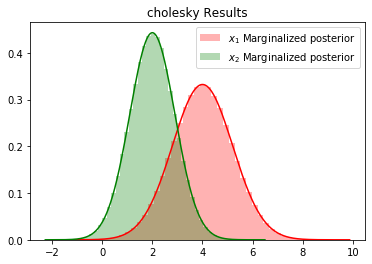

Simulation 95% credibility interval for for each parameter, after marginalizing over the other
 x1:  [1.64933852 6.35003837]
 x2:  [0.23481367 3.76517225] 

Relative error (wrt expected ones): 
 x1:  [0.00078596 0.00030202]
 x2:  [0.00516347 0.00032005] 

Simulation 95% credibility interval for for each parameter, with the other fixed to 2
 x1:  [2.19375161 5.80154593]
 x2:  [1.63477422 4.3662709 ] 

Relative error (wrt expected ones): 
 x1:  [0.00854895 0.00245597]
 x2:  [0.00016735 0.01176494]


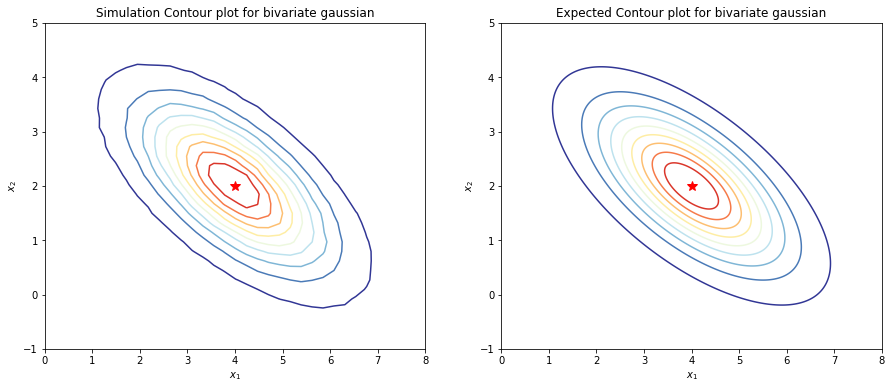

In [11]:
chain=Monte_Carlo_Sampling2D(mu,cov,num_epochs,'Cholesky')
credibility_intervals(chain,fixed_value)

### Metropolis-Hastings


Running Simulation...


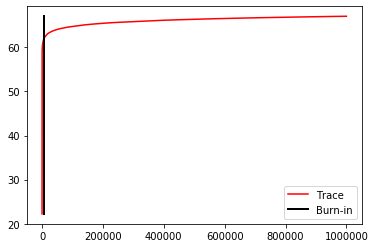

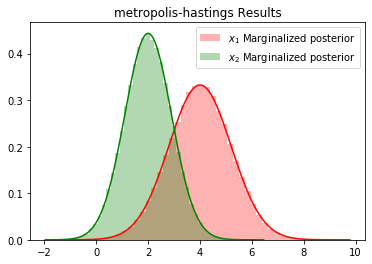

Simulation 95% credibility interval for for each parameter, after marginalizing over the other
 x1:  [1.65897584 6.34186976]
 x2:  [0.23712517 3.75983695] 

Relative error (wrt expected ones): 
 x1:  [0.0066337  0.00158802]
 x2:  [0.00462968 0.00109742] 

Simulation 95% credibility interval for for each parameter, with the other fixed to 2
 x1:  [2.28637598 5.69447991]
 x2:  [1.75389462 4.38783972] 

Relative error (wrt expected ones): 
 x1:  [0.03331201 0.01604409]
 x2:  [0.07304612 0.01676293]


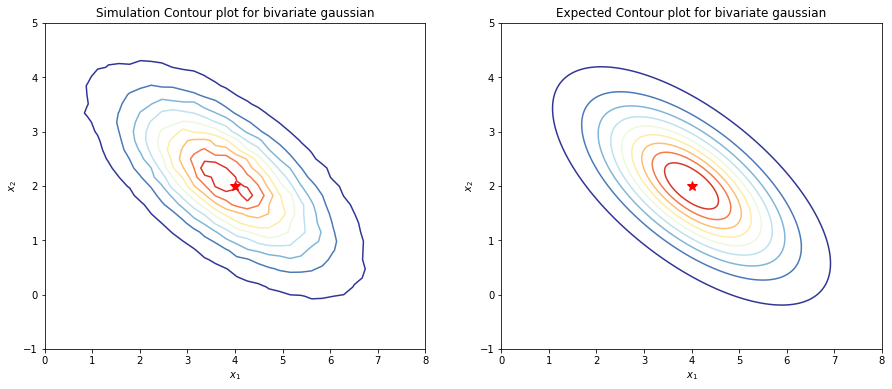

In [12]:
chain=Monte_Carlo_Sampling2D(mu,cov,num_epochs,'Metropolis-Hastings')
credibility_intervals(chain,fixed_value)

### Gibbs sampling


Running Simulation...


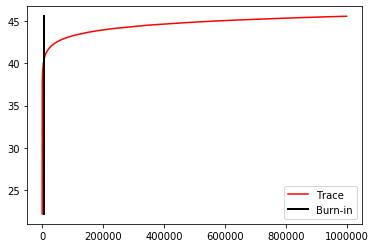

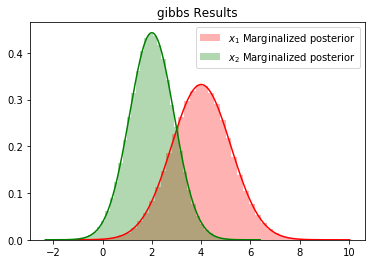

Simulation 95% credibility interval for for each parameter, after marginalizing over the other
 x1:  [1.64902217 6.35684036]
 x2:  [0.23503869 3.76272859] 

Relative error (wrt expected ones): 
 x1:  [0.00059401 0.00076883]
 x2:  [0.00421011 0.00032917] 

Simulation 95% credibility interval for for each parameter, with the other fixed to 2
 x1:  [2.28135029 5.84672816]
 x2:  [1.49666072 4.35795207] 

Relative error (wrt expected ones): 
 x1:  [0.03104068 0.01026306]
 x2:  [0.08433155 0.00983728]


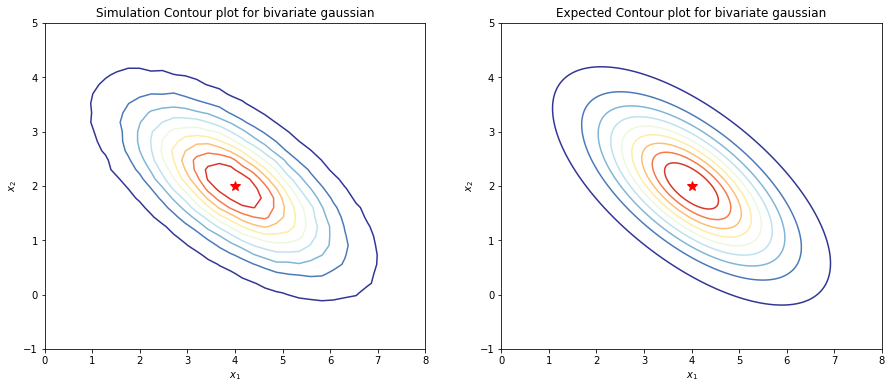

In [13]:
chain=Monte_Carlo_Sampling2D(mu,cov,num_epochs,'Gibbs')
credibility_intervals(chain,fixed_value)